# Q1 Gillespie's Direct Algorithm and Stochastic Hallmarks

Investigate
1. Variability
2. Negative co-variances
3. Increased transients
4. Stochastic resonance
5. Extinctions

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import scipy.stats as stats
from random import random

\begin{align}
\frac{dS}{dt} &= \mu -\beta SI - \mu S, \label{eq:dSdtDemo} \\
\frac{dI}{dt} &= \beta SI - \gamma I- I(\mu + \rho), \label{eq:dIdtDemo} \\
\frac{dR}{dt} &= \gamma I- \mu R. \label{eq:dRdtDemo}
\end{align}

In [3]:
def determinsteSIR(previousState, t, beta, gamma, birth_rate):
    N = np.sum(previousState)
    S,I,R = previousState/N
    state = np.empty(3)
    X,Y,Z = previousState
    state[0] = birth_rate - X*birth_rate - X*Y*beta
    state[1] = X*Y*beta   - Y*birth_rate - Y*gamma 
    state[2] = Y*gamma - Z*birth_rate
    return state
    

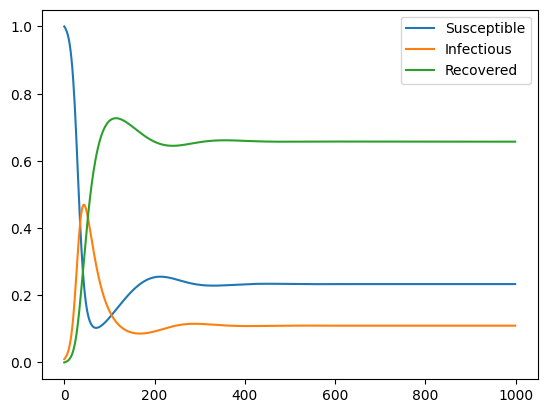

In [4]:
XYZ = [1, 0.01, 0]
t = np.linspace(0, 365, 1000)
beta = 1/2
gamma = 1/10
birth_rate = 1/60

solved = odeint(determinsteSIR, XYZ, t, (beta, gamma, mu))/10000
plt.plot(solved[:, 0], label = "Susceptible")
plt.plot(solved[:, 1], label = "Infectious")
plt.plot(solved[:, 2], label = "Recovered")
plt.legend(loc="best")

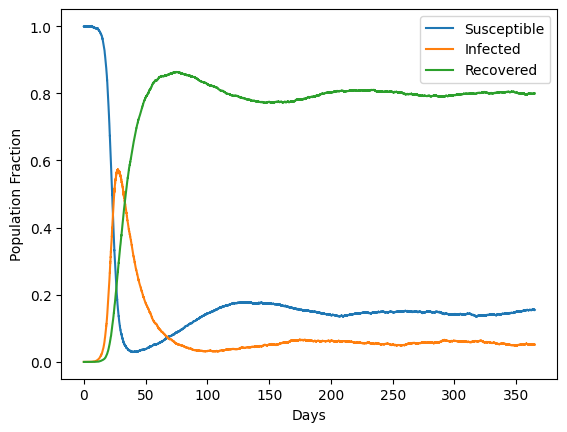

In [5]:
def stoch_sir(XYZ, N, tend, beta, gamma, mu):
    # Columns: SIR, Rows: Events [infect, recovery, birth, death S, death I, death R]
    change_matrix = np.array(
                            [[-1, 1, 0],
                             [0, -1, 1],
                             [1,  0, 0],
                             [-1, 0, 0],
                             [0, -1, 0],
                             [0,  0,-1]
                            ])
    current_t = 0
    ts = 0.1
    T = [0]
    S = [XYZ[0]]
    I = [XYZ[1]]
    R = [XYZ[2]]

    while T[current_t] < tend:
        T.append(T[-1] + ts)
        S.append(XYZ[0])
        I.append(XYZ[1])
        R.append(XYZ[2])

        update = np.zeros((6,3))
        event_rates = ([(beta * XYZ[0] * XYZ[1])/N, gamma * XYZ[1], 
                  mu * N,  mu * XYZ[0], mu * XYZ[1], mu * XYZ[2]])
         
        rand_1 = random()
        rand_2 = random()
        ts = -np.log(rand_1)/(np.sum(event_rates))

        p = rand_2 * np.sum(event_rates)
        event_index = min(np.nonzero(np.ravel(np.cumsum(event_rates) >= p))[0])
 
        XYZ = XYZ + change_matrix[event_index, :]
  
        current_t = current_t + 1
    return [T, S, I, R]
def run_simulations(number_of_runs, name, param, kwargs):
    for i in range(number_of_runs):
        df = pd.DataFrame(stoch_sir(**kwargs)).transpose()
        df.columns = ["T", "S", "I", "R"]
        df.to_csv(f"data/{name.capitalize()}{param}stochasticSIR{i+1}.csv", index=False)
runs = 100
# Varying Beta
for beta in np.linspace(0,4, 20):
    XYZ = np.array((10000, 1, 0))
    run_simulations(runs, "beta", beta,
                    {"XYZ": XYZ,
                     "N":np.sum(XYZ) ,
                     "tend":365,
                     "beta": beta,
                     "gamma":1/14,
                     "mu":1/200})
# Varying Gamma
for gamma in np.linspace(0,4, 20):
    XYZ = np.array((10000, 1, 0))
    run_simulations(runs, "gamma", gamma,
                    {"XYZ": XYZ,
                     "N":np.sum(XYZ) ,
                     "tend":365,
                     "beta": 1/2,
                     "gamma":gamma,
                     "mu":1/200})
# Varying Mu
for mu in np.linspace(0,0.1, 20):
    XYZ = np.array((10000, 1, 0))
    run_simulations(runs, "mu", mu,
                    {"XYZ": XYZ,
                     "N":np.sum(XYZ) ,
                     "tend":365,
                     "beta": 1/2,
                     "gamma":1/14,
                     "mu":mu})
# Varying N
for N in range(0,7):
    XYZ = np.array((10**N, 1, 0))
    run_simulations(runs, "N", 10**N,
                    {"XYZ": XYZ,
                     "N":np.sum(XYZ) ,
                     "tend":365,
                     "beta": 1/2,
                     "gamma":1/14,
                     "mu":1/200})

data_T = np.array(T)
data_S = np.array(S)/10000
data_I = np.array(I)/10000
data_R = np.array(R)/10000

plt.plot(data_T, data_S, data_T, data_I, data_T, data_R)
plt.xlabel("Days")
plt.ylabel("Population Fraction")
plt.legend(["Susceptible", "Infected", "Recovered"])
plt.show()


## Investigate Simulation variability and Negative Co-variance

> Investigate how varying the model parameters changes the behavior of the stochastic dynamics. How do the related to the variance between runs and the negative covariance between $S$ and $I$.

> Compare the mean of the stochatic models to their deterministic counter parts

Covariance between S and I - beta = 1/2, gamma = 1/10: 
-0.0018810532333314997
Covariance between S and I - beta = 1/2, gamma = 1/100: 
-0.0023630445573140325
Covariance between S and I - beta = 1/200, gamma = 1/10: 
-0.01691241718979449
Covariance between S and I - beta = 1/200, gamma = 1/100: 
0.0


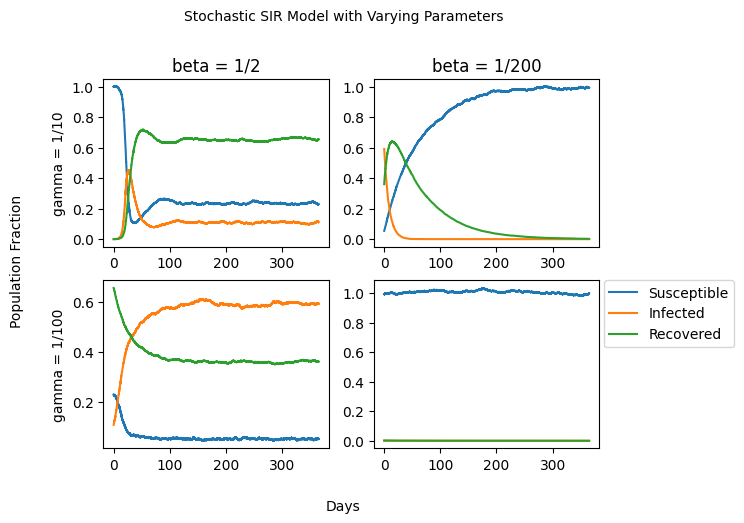

In [6]:
beta = 1/2
gamma = 1/10
mu = 1/60
XYZ = np.array((10000, 1, 0))
tend = 365
N = XYZ[0] + XYZ[1] + XYZ[2]

fig, axs = plt.subplots(2, 2)

[T, S, I, R] = stoch_sir(XYZ)

data_T1 = np.array(T)
data_S1 = np.array(S)/10000
data_I1 = np.array(I)/10000
data_R1 = np.array(R)/10000

cov = np.cov(data_S1, data_I1)
print("Covariance between S and I - beta = 1/2, gamma = 1/10: ")
print(cov[0,1])

beta = 1/2
gamma = 1/100
mu = 1/60

[T, S, I, R] = stoch_sir(XYZ)

data_T2 = np.array(T)
data_S2 = np.array(S)/10000
data_I2 = np.array(I)/10000
data_R2 = np.array(R)/10000

cov = np.cov(data_S2, data_I2)
print("Covariance between S and I - beta = 1/2, gamma = 1/100: ")
print(cov[0,1])

beta = 1/200
gamma = 1/10
mu = 1/60

[T, S, I, R] = stoch_sir(XYZ)

data_T3 = np.array(T)
data_S3 = np.array(S)/10000
data_I3 = np.array(I)/10000
data_R3 = np.array(R)/10000

cov = np.cov(data_S3, data_I3)
print("Covariance between S and I - beta = 1/200, gamma = 1/10: ")
print(cov[0,1])

beta = 1/200
gamma = 1/100
mu = 1/60

[T, S, I, R] = stoch_sir(XYZ)

data_T4 = np.array(T)
data_S4 = np.array(S)/10000
data_I4 = np.array(I)/10000
data_R4 = np.array(R)/10000

cov = np.cov(data_S4, data_I4)
print("Covariance between S and I - beta = 1/200, gamma = 1/100: ")
print(cov[0,1])

axs[0, 0].plot(data_T1, data_S1, data_T1, data_I1, data_T1, data_R1)
axs[0, 0].set_title("beta = 1/2")
axs[0, 0].set_ylabel("gamma = 1/10")
axs[1, 0].plot(data_T2, data_S2, data_T2, data_I2, data_T2, data_R2)
axs[1, 0].set_ylabel("gamma = 1/100")
axs[0, 1].plot(data_T3, data_S3, data_T3, data_I3, data_T3, data_R3)
axs[0, 1].set_title("beta = 1/200")
axs[1, 1].plot(data_T4, data_S4, data_T4, data_I4, data_T4, data_R4)

fig.text(0.5, -0.01, "Days", ha='center', va='center')
fig.text(-0.01, 0.5, "Population Fraction", ha='center', va='center', rotation='vertical')
fig.text(0.5, 1.01, "Stochastic SIR Model with Varying Parameters", ha='center', va='center', rotation='horizontal')
plt.legend(["Susceptible", "Infected", "Recovered"], bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)



In [8]:
mu = 1/60
XYZ = np.array((10000, 1, 0))
tend = 365
N = np.sum(XYZ)


beta = 1/2
gamma = 1/10
solved = odeint(determinsteSIR, XYZ, t, (beta, gamma, birth_rate))
test_t, pval = stats.ttest_ind(a=solved[:,0], b=data_S1, equal_var=False)
print(np.var(solved[:,0]), np.var(data_S1))
print("T stat: " + str(test_t))
print("P value: " + str(pval))
print()
beta = 1/2
gamma = 1/100
test_t, pval = stats.ttest_ind(a=solved[:,0], b=data_S2, equal_var=False)
print("T stat: " + str(test_t))
print("P value: " + str(pval))
print()
beta = 1/200
gamma = 1/10
test_t, pval = stats.ttest_ind(a=solved[:,0], b=data_S3, equal_var=False)
print("T stat: " + str(test_t))
print("P value: " + str(pval))
print()
beta = 1/200
gamma = 1/100
test_t, pval = stats.ttest_ind(a=solved[:,0], b=data_S4, equal_var=False)
print("T stat: " + str(test_t))
print("P value: " + str(pval))
print()


99896.5958818086 0.025679340794938943
T stat: 0.990222551914192
P value: 0.3223051255784004

T stat: 1.0108230884198988
P value: 0.3123458688131718

T stat: 0.9358845802426653
P value: 0.3495587915129439

T stat: 0.9164268920594117
P value: 0.35966420350467265



## Stochastic Resonance and Increase Transients
> Show how the stochatic models can induce stochatic resonance around the equilibiruim and how that resonance relates to the paramters.

> Show some example of increased transients away from the deterministic equilibiruim. Which parameters lead to the largest transient?

## Extinction events and Critical Community Size  
- Population in exponential scale
- Hand pick gamma
- Hope for an elbom (inflexion point)
> Design an experiment that shows the effect of varying $R_0$ on the extinction process. *Keep in mind that int he closed system randomness will always eventually lead to extinction*. 

> Look at how the extinction events are impacted by the population size. Find a way to show how the two parameter $R_0$ and $N$ ineract to imact the extinction process.

# Network
